In [109]:
import getpass
import pandas as pd
import numpy as np
from datalake_serpro import handler_dl
import matplotlib.pyplot as plot
import re
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split

<hr style="background:transparent; 2px;border-style:solid none;">

### Conexão com o Receita Data

In [ ]:
user = getpass.getuser() + '@XXXXXXXXXXXXXXXXX'
! {"echo '" + getpass.getpass('Senha para `kinit '+ user + '` : ') + "' | /opt/anaconda3/bin/kinit " + user}
print(80 * '-')
! /opt/anaconda3/bin/klist

In [ ]:
conexao = handler_dl(DEBUG=True, timeout=300)
conexao

<hr style="background:transparent; 2px;border-style:solid none;">

### Consultas SQL para obter os dados iniciais

In [58]:
sql_1='''SELECT DISTINCT t1.chave as chave_cte,
t1.fa01_cnpjemitente as CNPJ_emit,
t1.fa01_cnpjemitente_emp as CNPJ_emp,
t1.fa01_ip as ip,
t1.fb01_cfop_descricao as cfop_descricao,
t1.fb01_nct as num_cte,
t1.fb01_dtemi as data_emissao,
t1.fb01_hremi as hora_emissao,
t1.fb01_cmunenv as cod_municipio_envio,
t1.fb01_xmunenv as mun_envio,
t1.fb01_ufenv_codigo as cod_uf_envio,
t1.fb01_ufenv_descricao as uf_envio,
t1.fb01_modal_codigo as modal_cod,
t1.fb01_modal_descricao as modal,
t1.fb01_cmunini as cod_mun_inicio,
t1.fb01_xmunini as mun_inicio,
t1.fb01_ufini_codigo as cod_uf_inicio,
t1.fb01_ufini_descricao as uf_inicio,
t1.fb01_cmunfim as cod_municipio_fim,
t1.fb01_xmunfim as mun_fim,
t1.fb01_uffim_codigo as cod_uf_fim,
t1.fb01_uffim_descricao as uf_fim,
t1.fb01_retira as retira,
t1.fb01_xdetretira as local_retirada,
t1.fba01_ni as tomador_cnpj,
t1.fba01_ni_emp as tomador_cnpj_emp,
t1.fba01_xnome as tomador,
t1.fc01_xemi as funcionario_emissor,
t1.fc01_xobs as observações,
t1.fd01_cnpj as emitente,
t1.fd01_cnpj_emp as emitente_cnpj_emp,
t1.fd01_xnome as emitente_nome,
t1.fe01_ni as remetente,
t1.fe01_ni_emp as remetente_cnpj_emp,
t1.fe01_xnome as remetente_nome,
t1.fg01_cmun as recebedor_mun_cod,
t1.fg01_xmun as recebedor_municipio,
t1.fg01_uf_codigo as recebedor_uf_cod,
t1.fg01_uf_descricao as recebedor_uf,
t1.ff01_ni as expeditor,
t1.ff01_ni_emp as expeditor_cnpj_emp,
t1.ff01_xnome as expeditor_nome,
t1.fg01_ni as recebedor,
t1.fg01_ni_emp as recebedor_cnpj_emp,
t1.fg01_xnome as recebedor_nome,
t1.fh01_ni as destinatario,
t1.fh01_ni_emp as destinatario_cnpj_emp,
t1.fh01_xnome as destinatario_nome,
t1.fh01_cmun as destinatario_mun_cod,
t1.fh01_xmun as destinatario_municipio,
t1.fh01_uf_codigo as destinatario_uf_cod,
t1.fh01_uf_descricao as destinatario_descricao,
t1.fh02_ni as local_entrega,
t1.fh02_ni_emp as local_entrega_cnpj_emp,
t1.fh02_xnome as local_entrega_nome,
t1.fh02_cmun as local_entrega_mun_cod,
t1.fh02_xmun as local_entrega_municipio,
t1.fh02_uf_codigo as local_entrega_uf_cod,
t1.fh02_uf_descricao as local_entrega_uf,
t1.fka334_xdime as carga_dimensao,
t1.fka600_chcte as cte_substituicao_chave,
t1.fKA700_xObs as obs,
t2.fKA46_chave as nfe_chave
FROM contagil_cte.cte_v6_a01 as t1 LEFT JOIN contagil_cte.cte_v6_ka46 as t2 ON t1.chave=t2.chave 
where t1.fb01_xmunfim='JOINVILLE' AND t1.fb01_dtemi BETWEEN '2020-09-01' and '2020-09-10'
'''

In [59]:
df_atr_1=pd.read_sql(sql_1, conexao)

In [ ]:
df_atr_1.shape

<h><b> SQL para consulta auxiliar: Valor Frete </b><h>

In [61]:
sql_2='''SELECT DISTINCT t1.chave as chave_cte,t1.fi01_vtprest as valor_prestacao
FROM contagil_cte.cte_v6_a01 as t1 
where t1.fi01_vtprest >0.0 and t1.fb01_xmunfim='JOINVILLE' AND t1.fb01_dtemi BETWEEN '2020-09-01' and '2020-09-10'
'''

In [62]:
df_atr_2=pd.read_sql(sql_2, conexao)

In [ ]:
df_atr_2.shape

<h><b> SQL para consulta auxiliar: Produto prepoderante </b> <h>

In [64]:
sql_3='''SELECT DISTINCT t1.chave as chave_cte, t1.fka01_propred as produto_predominante
FROM contagil_cte.cte_v6_a01 as t1 
where t1.fka01_propred <> 'NULL' AND t1.fb01_xmunfim='JOINVILLE' AND t1.fb01_dtemi BETWEEN '2020-09-01' and '2020-09-10'
'''

In [65]:
df_atr_3=pd.read_sql(sql_3, conexao)

In [ ]:
df_atr_3.shape

<h><b> SQL para consulta auxiliar: Valor Carga</b> <h>

In [67]:
sql_4='''SELECT DISTINCT t1.chave as chave_cte, t1.fka01_vcarga as valor_carga
FROM contagil_cte.cte_v6_a01 as t1 
where t1.fka01_vcarga > 0.0 AND t1.fb01_xmunfim='JOINVILLE' AND t1.fb01_dtemi BETWEEN '2020-09-01' and '2020-09-10'
'''

In [68]:
df_atr_4=pd.read_sql(sql_4, conexao)

In [ ]:
df_atr_4.shape

<h><b> Definição das chaves <b><h>

In [70]:
df_atr_1.set_index('chave_cte', inplace=True)

In [71]:
df_atr_2.set_index('chave_cte', inplace=True)

In [72]:
df_atr_3.set_index('chave_cte', inplace=True)

In [73]:
df_atr_4.set_index('chave_cte', inplace=True)

<h><b> Junções das tabelas </b><h>

In [74]:
df_r1=df_atr_1.merge(df_atr_2,how='left', left_index=True,right_index=True)

In [ ]:
df_r1.shape

In [76]:
df_r2=df_r1.merge(df_atr_3,how='left', left_index=True,right_index=True)


In [ ]:
df_r2.shape

In [78]:
df_r3=df_r2.merge(df_atr_4,how='left', left_index=True,right_index=True)

In [ ]:
df_r3.shape

<h><b>Verificação dos tipos</b></h>

In [80]:
tipos=df_r3.dtypes

In [81]:
tipos.to_csv('tipos.csv')

In [ ]:
lista_categoricos = df_r3.describe(exclude='number',datetime_is_numeric=True).T.query('unique < 6').index.to_list()
lista_categoricos

In [83]:
df_r3['modal']=df_r3['modal'].astype('category')

In [ ]:
df_r3['modal'].value_counts().to_frame()

In [87]:
def exemplo_linha(frame, iloc=0):
    df_info = pd.DataFrame(dict(valor_exemplo=frame.iloc[iloc].copy()))
    df_info['dtype_coluna'] = frame.dtypes.map(lambda x: x.name)
    df_info['classe_valor'] = df_info['valor_exemplo'].map(lambda x: x.__class__.__name__)
    df_info.index.name = 'nome_coluna'
    return df_info

In [88]:
df_info = exemplo_linha(df_r3)
df_info.to_csv('tipos3.csv')

In [89]:
df_r3.drop(columns=['cnpj_emp'], inplace=True)

In [90]:
df_r3.drop(['cnpj_emit','ip','local_retirada','tomador_cnpj','tomador_cnpj_emp','tomador','funcionario_emissor','local_entrega','local_entrega_cnpj_emp','local_entrega_nome','local_entrega_mun_cod','local_entrega_municipio','local_entrega_uf_cod','local_entrega_uf','carga_dimensao','obs'], axis=1,inplace=True)

In [ ]:
df_r3.shape

In [92]:
df_info2 = exemplo_linha(df_r3)
df_info2.to_csv('tipos4.csv')

In [93]:
df_r3['remetente_cnpj_emp'].fillna(0, inplace=True)

In [94]:
df_r3['expeditor_cnpj_emp'].fillna(0, inplace=True)

In [95]:
df_r3['recebedor_cnpj_emp'].fillna(0, inplace=True)

In [96]:
df_r3['destinatario_cnpj_emp'].fillna(0, inplace=True)

In [97]:
df_r3['emitente_cnpj_emp']=df_r3.astype({'emitente_cnpj_emp':'int64'}).dtypes

In [98]:
df_r3['expeditor_cnpj_emp']=df_r3.astype({'expeditor_cnpj_emp':'int64'}).dtypes

In [99]:
df_r3['recebedor_cnpj_emp']=df_r3.astype({'recebedor_cnpj_emp':'int64'}).dtypes

In [100]:
df_r3['destinatario_cnpj_emp']=df_r3.astype({'destinatario_cnpj_emp':'int64'}).dtypes

In [101]:
df_r3['remetente_cnpj_emp']=df_r3.astype({'remetente_cnpj_emp':'int64'}).dtypes

In [ ]:
df_r3.dropna(axis=0, how='all')

In [103]:
df_r3.to_csv('base_inf.csv')

In [47]:
estado=df_r3.groupby(by=['cod_uf_inicio'])
estado_contagem=estado['num_cte'].count()
estado_contagem

cod_uf_inicio
AL       66
AM       72
BA      146
CE       72
DF       55
ES      968
GO      157
MA       12
MG     2248
MS       68
MT       45
PA       18
PB       41
PE      181
PI       11
PR     6718
RJ      920
RN       13
RO        9
RR        3
RS     2550
SC    10893
SE       12
SP    17203
TO       30
Name: num_cte, dtype: int64

<AxesSubplot:>

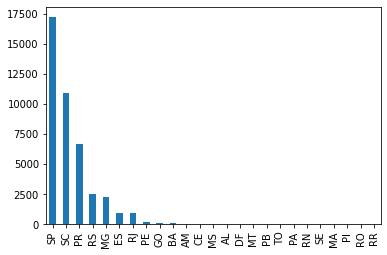

In [48]:
df_r3['cod_uf_inicio'].value_counts().plot.bar()

In [49]:
retira=df_r3.groupby(by=['retira'])
retira_contagem=retira['num_cte'].count()
retira_contagem

retira
False     6051
True     36460
Name: num_cte, dtype: int64

<AxesSubplot:>

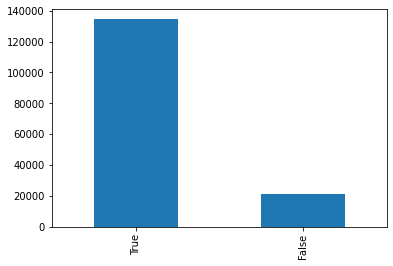

In [44]:
df_r3['retira'].value_counts().plot.bar()

In [77]:
data2=df_r3.groupby(by=['data_emissao'])
data_contagem=data2['num_cte'].count()
data_contagem


data_emissao
2020-09-01    20751
2020-09-02    22738
2020-09-03    20316
2020-09-04    19648
2020-09-05     5399
2020-09-06      968
2020-09-07     3045
2020-09-08    20049
2020-09-09    20862
2020-09-10    21667
Name: num_cte, dtype: int64

<AxesSubplot:>

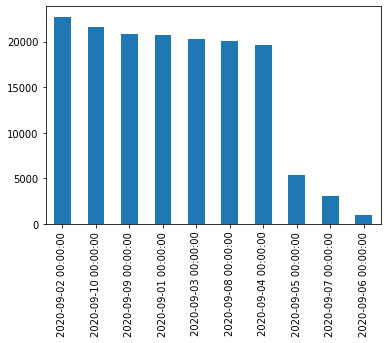

In [76]:
df_r3['data_emissao'].value_counts().plot.bar()

In [78]:
df_r3['valor_carga'].sum()

4864391300.500001

In [79]:
df_r3['valor_carga'].mean()

31651.904560659124

In [80]:
df_r3['valor_prestacao'].sum()

81151107.92

In [92]:
df_r3['valor_prestacao'].mean()

522.5475239375547

<AxesSubplot:>

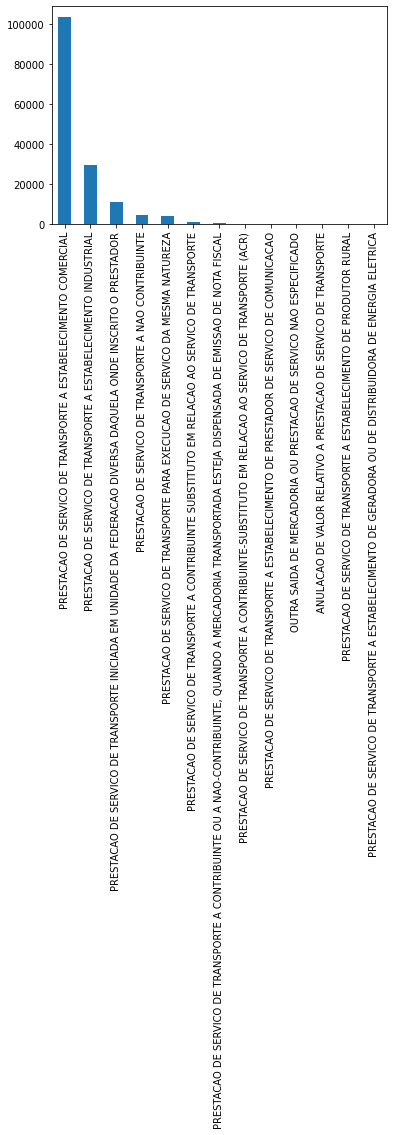

In [101]:
df_r3['cfop_descricao'].value_counts().plot.bar()